In [1]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# .mgf file

In [3]:
mgf = open('data/massIVE-KB/LIBRARY_CREATION_AUGMENT_LIBRARY_TEST-82c0124b-download_filtered_mgf_library-main.mgf')
for _ in range(100):
    print(mgf.readline())
mgf.close()

BEGIN IONS

PEPMASS=623.3276257633

CHARGE=3

MSLEVEL=2

COLLISION_ENERGY=0.0

FILENAME=filtered_library_mgf_files/9187af535f6e41ce9583b4553469c20e.mgf

SEQ=+42.011AAEAAGGKYRSTVSKSKD

PROTEIN=sp|Q96A65|EXOC4_HUMAN

SCANS=1

SCAN=1

SCORE=4.6051746015

FDR=0.0

129.10317993164062	63295.375

130.08726501464844	7010.876953125

136.07666015625	14278.6826171875

143.0828857421875	5026.0068359375

147.11407470703125	7820.40576171875

155.08229064941406	4797.83935546875

161.09341430664062	12979.1123046875

173.09310913085938	12697.0185546875

185.09327697753906	46881.85546875

189.08819580078125	8073.11181640625

198.1256561279297	5272.4541015625

201.08811950683594	40607.234375

216.13560485839844	25192.845703125

262.1419982910156	13653.341796875

272.1259765625	9055.1015625

314.1366882324219	39298.5859375

315.1393737792969	6137.8544921875

349.172607421875	12984.642578125

385.17431640625	22504.26953125

397.213623046875	10097.7060546875

444.7332763671875	4657.58154296875

495.26116943

In [8]:
kb = open('data/massIVE-KB/LIBRARY_CREATION_AUGMENT_LIBRARY_TEST-82c0124b-download_filtered_mgf_library-main.mgf', 'r')
kblines = kb.readlines()
kb.close()
rows = {'PEPMASS':[], 'CHARGE':[], 'MSLEVEL':[], 'COLLISION_ENERGY':[], 'FILENAME':[], 'SEQ':[],
       'PROTEIN':[], 'STRIP_PEPTIDE':[], 'SCANS':[], 'SCAN':[], 'SCORE':[], 'FDR':[]}
for line in kblines:
    line = line.replace('\n', '')
    if 'PEPMASS=' in line:
        rows['PEPMASS'].append(line.replace('PEPMASS=', ''))
    elif 'CHARGE=' in line:
        rows['CHARGE'].append(line.replace('CHARGE=', ''))
    elif 'MSLEVEL=' in line:
        rows['MSLEVEL'].append(line.replace('MSLEVEL=', ''))
    elif 'COLLISION_ENERGY=' in line:
        rows['COLLISION_ENERGY'].append(line.replace('COLLISION_ENERGY=', ''))
    elif 'FILENAME=' in line:
        rows['FILENAME'].append(line.replace('FILENAME=', ''))
    elif 'SEQ=' in line:
        rows['SEQ'].append(line.replace('SEQ=', ''))
        rows['STRIP_PEPTIDE'].append(''.join(list(filter(lambda x: ord(x) in range(65, 91), line.replace('SEQ=', '')))))
    elif 'PROTEIN=' in line:
        rows['PROTEIN'].append(line.replace('PROTEIN=', ''))
    elif 'SCANS=' in line:
        rows['SCANS'].append(line.replace('SCANS=', ''))
    elif 'SCAN=' in line:
        rows['SCAN'].append(line.replace('SCAN=', ''))
    elif 'SCORE=' in line:
        rows['SCORE'].append(line.replace('SCORE=', ''))
    elif 'FDR=' in line:
        rows['FDR'].append(line.replace('FDR=', ''))
        

# All Candidate Library Spectra

In [7]:
df_candi = pd.read_csv('data/massIVE-KB/LIBRARY_CREATION_AUGMENT_LIBRARY_TEST-82c0124b-candidate_library_spectra-main.tsv', sep='\t')

In [16]:
print(df_candi.shape)
df_candi.head()

(30633841, 17)


,annotated_peak_count,annotation,augment_task,charge,explained_intensity,extract_task,filename,kl_score,most_similar_score,mz,number_of_ions_annotated_above_SNR,number_of_peaks_within_1_percent_of_max,ppm_error,precursor_intensity,proteosafe_task,scan,score
0,29,-17.027QAAAAAAAAAATAAWTGTTF,818a7b41e3994f1f83801a7d625bcdd7,2,0.773831,8fd4d62a97cf472cbb0f74b907f0a572,MSV000080813/ccms_peak/RAW/20130426_EXQ6_SaDe_...,-1.000000,0.900479,888.935677,47,149,5.307678,5.296381e+05,173516dbe1a1405290fa01276cc084f1,94572,3.857783
1,32,-17.027QAAAAAAAAAATAAWTGTTF,19eab28787264e089157a616fcdda792,2,0.827863,888400a2034e47f7898b255c8b79dac9,MSV000080679/peak/peak/j10848_ZYX.mzXML,0.001657,0.886112,888.927783,37,118,3.572741,3.887555e+06,345c4bf040874398a5cfec713050ff0f,21577,3.497227
2,32,-17.027QAAAAAAAAAATAAWTGTTF,35c56d4519fa44c6b7287892e8a7f0ec,2,0.540547,d1cd722751584c619144ed879b9934bb,MSV000080757/ccms_peak/RAW/20110616_EXQ1_TaGe_...,-1.000000,0.775026,888.934480,76,285,3.961430,2.346980e+06,fa7c0bf63fd54897880f5c56ef80a6f5,104380,3.268185
3,32,-17.027QAAAAAAAAAATAAWTGTTF,818a7b41e3994f1f83801a7d625bcdd7,2,0.775265,8fd4d62a97cf472cbb0f74b907f0a572,MSV000080813/ccms_peak/RAW/20130427_EXQ6_SaDe_...,-1.000000,0.904331,888.936565,49,155,6.306464,5.904183e+05,26c1bc0429404acd9dccafc5b602efab,94284,3.852062
4,34,-17.027QAAAAAAAAAATAAWTGTTF,818a7b41e3994f1f83801a7d625bcdd7,2,0.746305,8fd4d62a97cf472cbb0f74b907f0a572,MSV000080813/ccms_peak/RAW/20130427_EXQ6_SaDe_...,-1.000000,0.892268,888.932956,43,179,2.246572,5.344557e+05,173516dbe1a1405290fa01276cc084f1,88022,4.024928


In [26]:
candi = [''.join(re.findall('[a-zA-Z]', pep)) for pep in df_candi.annotation.values]

In [61]:
print('unique peptide : {:,}'.format(len(set(candi))))

unique peptide : 1,115,926


In [29]:
candi_dic = {k:0 for k in candi}
for k in candi:
    candi_dic[k] += 1

In [32]:
sorted(candi_dic.items(), key=lambda x: x[1], reverse=True)

[('VADALTNAVAHVDDMPNALSALSDLHAHK', 2212),
 ('KVADALTNAVAHVDDMPNALSALSDLHAHK', 2103),
 ('HTGPGILSMANAGPNTNGSQFFICTAK', 1613),
 ('IITITGTQDQIQNAQYLLQNSVK', 1583),
 ('WQQGNVFSCSVMHEALHNHYTQK', 1558),
 ('QLFHPEQLITGKEDAANNYAR', 1503),
 ('MSVQPTVSLGGFEITPPVVLR', 1484),
 ('HIADLAGNSEVILPVPAFNVINGGSHAGNK', 1482),
 ('VIHDNFGIVEGLMTTVHAITATQK', 1443),
 ('HQGVMVGMGQKDSYVGDEAQSKR', 1401),
 ('LHEEEIQELQAQIQEQHVQIDVDVSKPDLTAALR', 1401),
 ('QEPERNECFLQHKDDNPNLPR', 1400),
 ('SGPFGQIFRPDNFVFGQSGAGNNWAK', 1366),
 ('AMGIMNSFVNDIFER', 1339),
 ('LVQDVANNTNEEAGDGTTTATVLAR', 1327),
 ('VDNALQSGNSQESVTEQDSK', 1316),
 ('VTIAQGGVLPNIQAVLLPK', 1303),
 ('GILGYTEHQVVSSDFNSDTHSSTFDAGAGIALNDHFVK', 1302),
 ('NNQFQALLQYADPVSAQHAK', 1298),
 ('HQGVMVGMGQK', 1297),
 ('TTGIVMDSGDGVTHTVPIYEGYALPHAILR', 1288),
 ('LRFPAEDEFPDLSAHNNHMAK', 1282),
 ('QISNLQQSISDAEQR', 1280),
 ('VIISAPSADAPMFVMGVNHEK', 1279),
 ('RVIISAPSADAPMFVMGVNHEK', 1272),
 ('YPIEHGIITNWDDMEKIWHHTFYNELR', 1270),
 ('LQDEIQNMKEEMAR', 1269),
 ('PSQMEHAMETMMFTFH

In [49]:
paren = sorted(candi_dic.items(), key=lambda x: x[1], reverse=True)
x = [i[0] for i in paren]
x = range(len(x))
y = [i[1] for i in paren]

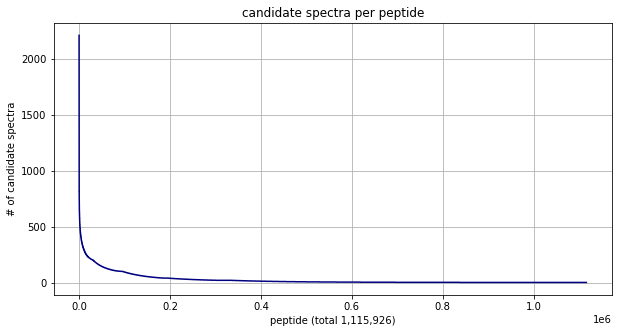

In [58]:
plt.figure(figsize=(10,5))
plt.plot(x, y, color='navy')
plt.xlabel('peptide (total 1,115,926)')
plt.ylabel('# of candidate spectra')
plt.title('candidate spectra per peptide')
# plt.ylim(0, 500)
plt.grid()
plt.show()

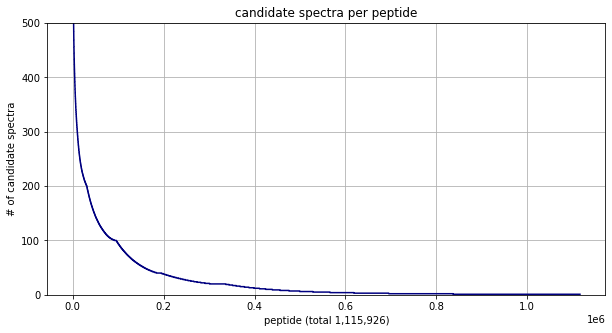

In [57]:
plt.figure(figsize=(10,5))
plt.plot(x, y, color='navy')
plt.xlabel('peptide (total 1,115,926)')
plt.ylabel('# of candidate spectra')
plt.title('candidate spectra per peptide')
plt.ylim(0, 500)
plt.grid()
plt.show()

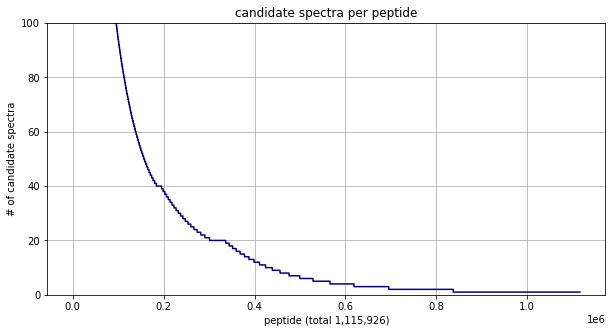

In [59]:
plt.figure(figsize=(10,5))
plt.plot(x, y, color='navy')
plt.xlabel('peptide (total 1,115,926)')
plt.ylabel('# of candidate spectra')
plt.title('candidate spectra per peptide')
plt.ylim(0, 100)
plt.grid()
plt.show()

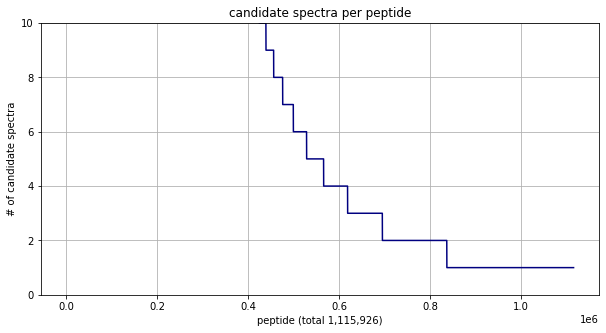

In [60]:
plt.figure(figsize=(10,5))
plt.plot(x, y, color='navy')
plt.xlabel('peptide (total 1,115,926)')
plt.ylabel('# of candidate spectra')
plt.title('candidate spectra per peptide')
plt.ylim(0, 10)
plt.grid()
plt.show()

* 210114 : 단순히 candidate spectra가 아니라 experiment 를 얘기한 것
  - filename 으로 구분하면 될듯하다.

In [67]:
print('unique file cnt : {:,}'.format(len(df_candi.filename.unique())))

unique file cnt : 27,992


In [81]:
# peptide : filename 으로 filename 2개 이상인 펩타이드만 찾을 것.
candi_expdic = {i:set() for i in candi}

for peps, fn in df_candi[['annotation', 'filename']].values:
    pep = ''.join(re.findall('[a-zA-Z]', peps))
    candi_expdic[pep].add(fn)

candi_exp = {pep:len(v) for pep, v in candi_expdic.items()}

In [92]:
sorted(candi_exp.items(), key=lambda x: x[1], reverse=True)

[('QLFHPEQLITGKEDAANNYAR', 1003),
 ('QTQTFTTYSDNQPGVLIQVYEGER', 923),
 ('HQGVMVGMGQK', 902),
 ('IITITGTQDQIQNAQYLLQNSVK', 889),
 ('SGPFGQIFRPDNFVFGQSGAGNNWAK', 838),
 ('AMGIMNSFVNDIFER', 836),
 ('LVINGNPITIFQERDPSK', 822),
 ('HIADLAGNSEVILPVPAFNVINGGSHAGNK', 820),
 ('VIHDNFGIVEGLMTTVHAITATQK', 811),
 ('VADALTNAVAHVDDMPNALSALSDLHAHK', 808),
 ('LVQDVANNTNEEAGDGTTTATVLAR', 804),
 ('VDNALQSGNSQESVTEQDSK', 800),
 ('DIENQYETQITQIEHEVSSSGQEVQSSAK', 788),
 ('MSVQPTVSLGGFEITPPVVLR', 768),
 ('VTIAQGGVLPNIQAVLLPK', 764),
 ('TVTNAVVTVPAYFNDSQR', 762),
 ('HTGPGILSMANAGPNTNGSQFFICTAK', 756),
 ('KDLYANTVLSGGTTMYPGIADR', 754),
 ('QTQIFTTYSDNQPGVLIQVYEGER', 750),
 ('VFDEFKPLVEEPQNLIK', 743),
 ('LAMQEFMILPVGAANFR', 738),
 ('VIISAPSADAPMFVMGVNHEK', 737),
 ('TTGIVMDSGDGVTHTVPIYEGYALPHAILR', 728),
 ('QEPERNECFLQHKDDNPNLPR', 717),
 ('SQYEQLAEQNRK', 715),
 ('EVDEQMLNVQNK', 714),
 ('LNFSHGTHEYHAETIK', 714),
 ('NNQFQALLQYADPVSAQHAK', 710),
 ('DLYANTVLSGGTTMYPGIADR', 705),
 ('IGEHTPSALAIMENANVLAR', 703),
 ('QIS

In [93]:
paren2 = sorted(candi_exp.items(), key=lambda x: x[1], reverse=True)
x = [i[0] for i in paren2]
x = range(len(x))
y = [i[1] for i in paren2]

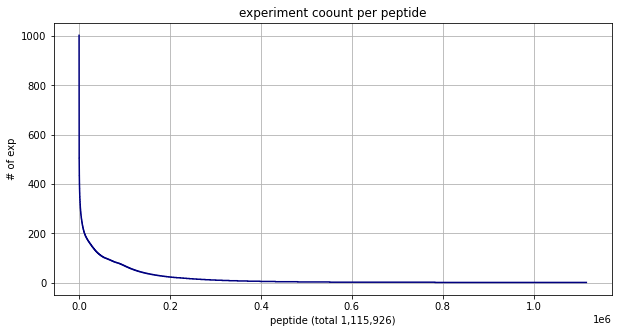

In [154]:
plt.figure(figsize=(10,5))
plt.plot(x, y, color='navy')
plt.xlabel('peptide (total 1,115,926)')
plt.ylabel('# of exp')
plt.title('experiment coount per peptide')
# plt.ylim(0, 500)
plt.grid()
plt.show()

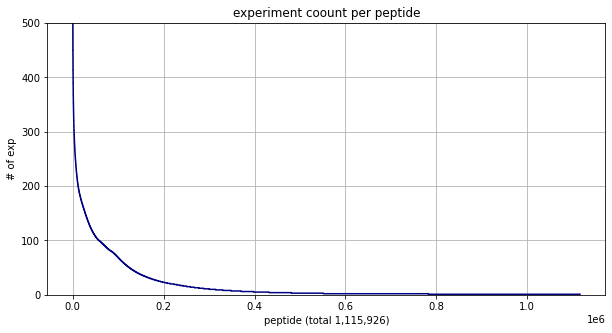

In [155]:
plt.figure(figsize=(10,5))
plt.plot(x, y, color='navy')
plt.xlabel('peptide (total 1,115,926)')
plt.ylabel('# of exp')
plt.title('experiment coount per peptide')
plt.ylim(0, 500)
plt.grid()
plt.show()

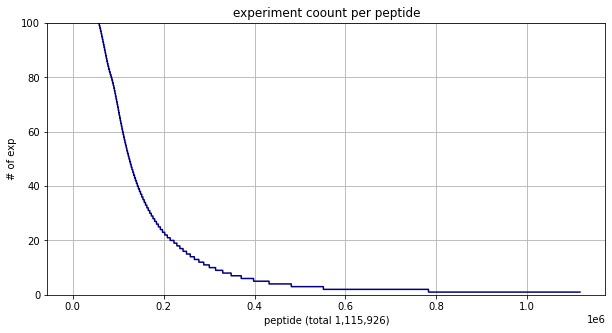

In [156]:
plt.figure(figsize=(10,5))
plt.plot(x, y, color='navy')
plt.xlabel('peptide (total 1,115,926)')
plt.ylabel('# of exp')
plt.title('experiment coount per peptide')
plt.ylim(0, 100)
plt.grid()
plt.show()

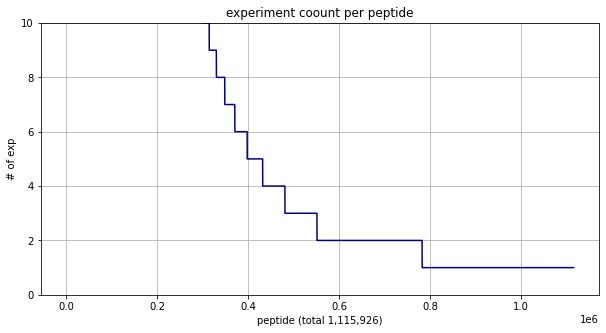

In [157]:
plt.figure(figsize=(10,5))
plt.plot(x, y, color='navy')
plt.xlabel('peptide (total 1,115,926)')
plt.ylabel('# of exp')
plt.title('experiment coount per peptide')
plt.ylim(0, 10)
plt.grid()
plt.show()

In [99]:
result_pep = [pep for pep, v in paren2 if v>=2]

In [103]:
len(set(result_pep)), len(result_pep)

(782563, 782563)

* 210114
  - peptide 는 78만개로 줄였는데, 얘들이 어디 protein인지 확인필요
  - 또, 기존에 peptide 110만개 중에 있는 78만개가 맞는지 검증필요

In [105]:
# 기존 110만개 peptide와 비교

In [ ]:
ori_pep = [''.join(re.findall('[A-Z]', i[4:])) for i in mgff if 'SEQ=' in i]
compare = [i for i in result_pep if i in ori_pep]
# 40분

In [121]:
print('result pep 중, ori_pep에 있는 개수 : {:,}'.format(len(compare)))

result pep 중, ori_pep에 있는 개수 : 772,868


In [145]:
df_compare = pd.DataFrame(compare, columns=['pep_co'])
df_result = pd.DataFrame(result_pep, columns=['pep_re'])

df_what = df_result.merge(df_compare, left_on='pep_re', right_on='pep_co', how='left')

what = df_what.loc[df_what['pep_co'].isnull()].pep_re.values

In [147]:
print("mgf 파일에는 없지만 candidate 파일에서 추가적으로 나온 {:,}개 peptide\n".format(len(what)), what)

mgf 파일에는 없지만 candidate 파일에서 추가적으로 나온 9,695개 peptide
 ['QLLQANPILEAFGNAK' 'EIVHLQAGQCGNQIGAK' 'QIFHPEQLITGK' ... 'YYGNVTR'
 'YYNQSEDGSHTIQR' 'YYVDHNTK']


In [153]:
# 위 추가로 나온 candidate peptide는 빼고, 77만개로 진행
# df_compare.to_csv('data/multishot/LIBRARY_CREATION_AUGMENT_LIBRARY_TEST-82c0124b-candidate_peptide.csv', index=False)

# protein list file
  - protein file

In [3]:
df_prot = pd.read_csv('../data/multishot/LIBRARY_CREATION_AUGMENT_LIBRARY_TEST-82c0124b-protein_list-main.tsv', sep='\t')

In [4]:
df_prot.drop(['Unnamed: 11'], axis=1, inplace=True)
print(df_prot.shape)
df_prot.head()

(40258, 11)


,fdr,length,nextprot_antibody,nextprot_pe_number,nextprot_proteomics,nextprot_text_desc,number_of_non_overlapping_sequences,number_precursors,pe_number,protein,score
0,0.0,1000,yes,1,yes,Evidence at protein level,66,142,1,sp|Q86YS7|C2CD5_HUMAN,1078.343432
1,0.0,1000,yes,1,yes,Evidence at protein level,73,251,1,sp|Q9Y6Y8|S23IP_HUMAN,1910.129206
2,0.0,1001,yes,1,no,Evidence at protein level,21,48,1,sp|Q2VWA4|SKOR2_HUMAN,547.627844
3,0.0,1001,yes,1,yes,Evidence at protein level,23,45,2,sp|Q8N283|ANR35_HUMAN,362.596184
4,0.0,1001,yes,1,yes,Evidence at protein level,25,73,1,sp|O14983|AT2A1_HUMAN,477.961997


In [5]:
len(df_prot.protein.unique())

40258

In [6]:
df_prot.nextprot_pe_number.unique()

array([1, 2, 5, 4, 3, 0])

In [7]:
df_prot.nextprot_text_desc.unique()

array(['Evidence at protein level', 'Evidence at transcript level',
       'Uncertain', 'Predicted', 'Inferred from homology', '0'],
      dtype=object)

In [8]:
df_prot.pe_number.unique()

array(['1', '2', ' ', '5', '4', '3'], dtype=object)

In [9]:
df_prot.loc[df_prot.nextprot_pe_number==1]

,fdr,length,nextprot_antibody,nextprot_pe_number,nextprot_proteomics,nextprot_text_desc,number_of_non_overlapping_sequences,number_precursors,pe_number,protein,score
0,0.0,1000,yes,1,yes,Evidence at protein level,66,142,1,sp|Q86YS7|C2CD5_HUMAN,1078.343432
1,0.0,1000,yes,1,yes,Evidence at protein level,73,251,1,sp|Q9Y6Y8|S23IP_HUMAN,1910.129206
2,0.0,1001,yes,1,no,Evidence at protein level,21,48,1,sp|Q2VWA4|SKOR2_HUMAN,547.627844
3,0.0,1001,yes,1,yes,Evidence at protein level,23,45,2,sp|Q8N283|ANR35_HUMAN,362.596184
4,0.0,1001,yes,1,yes,Evidence at protein level,25,73,1,sp|O14983|AT2A1_HUMAN,477.961997
...,...,...,...,...,...,...,...,...,...,...,...
40252,1.0,99,yes,1,yes,Evidence at protein level,0,0,,XXX_sp|Q0VGL1|LTOR4_HUMAN,-1000.000000
40253,1.0,99,yes,1,yes,Evidence at protein level,0,0,,XXX_sp|Q96QK8|SIM14_HUMAN,-1000.000000
40254,1.0,99,yes,1,yes,Evidence at protein level,0,0,,XXX_sp|Q9C005|DPY30_HUMAN,-1000.000000
40255,1.0,99,yes,1,yes,Evidence at protein level,0,0,,XXX_sp|Q9H1M4|DB127_HUMAN,-1000.000000


In [11]:
decoy_idx = [idx for idx, i in enumerate(df_prot.protein.values) if 'XXX' in i]
df_prot_ed = df_prot.drop(decoy_idx)
df_prot_ed.loc[df_prot_ed.nextprot_pe_number==1]

,fdr,length,nextprot_antibody,nextprot_pe_number,nextprot_proteomics,nextprot_text_desc,number_of_non_overlapping_sequences,number_precursors,pe_number,protein,score
0,0.0,1000,yes,1,yes,Evidence at protein level,66,142,1,sp|Q86YS7|C2CD5_HUMAN,1078.343432
1,0.0,1000,yes,1,yes,Evidence at protein level,73,251,1,sp|Q9Y6Y8|S23IP_HUMAN,1910.129206
2,0.0,1001,yes,1,no,Evidence at protein level,21,48,1,sp|Q2VWA4|SKOR2_HUMAN,547.627844
3,0.0,1001,yes,1,yes,Evidence at protein level,23,45,2,sp|Q8N283|ANR35_HUMAN,362.596184
4,0.0,1001,yes,1,yes,Evidence at protein level,25,73,1,sp|O14983|AT2A1_HUMAN,477.961997
...,...,...,...,...,...,...,...,...,...,...,...
39745,1.0,92,yes,1,yes,Evidence at protein level,0,0,1,sp|Q9P2X0|DPM3_HUMAN,-1000.000000
40041,1.0,96,no,1,yes,Evidence at protein level,0,0,1,sp|P60328|KR123_HUMAN,-1000.000000
40042,1.0,96,no,1,yes,Evidence at protein level,0,0,1,sp|Q8TF09|DLRB2_HUMAN,-1000.000000
40121,1.0,97,yes,1,yes,Evidence at protein level,0,0,1,sp|Q9BXN6|SPNXD_HUMAN,-1000.000000
